In [1]:
import numpy as np
import simulation_manager, results_annalysis
import instance_genrerantion
from scipy.optimize import dual_annealing
from problem_reductions import npp_to_ising
import time
import random
import networkx as nx
import math
import matplotlib.pyplot as plt
from scipy.linalg import eigh

In [2]:
def read_graph(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        N, E = map(int, lines[0].split())
        graph = np.zeros((N, N))
        for line in lines[1:]:
            i, j, w = map(int, line.split())
            graph[i-1, j-1] = w
            graph[j-1, i-1] = w  # since the graph is undirected
            
    return np.array(graph)

In [3]:
graph = read_graph('MAX-CUT dataset/G24')

In [4]:
np.sqrt(graph.size)

2000.0

In [5]:
size = 2000
graph = graph[:size, :size]

In [6]:
J = graph/2
# np.fill_diagonal(J, 0)
H = np.zeros(size)
# H = 100*J[0, :]
# J, H = instance_genrerantion.generate_instance(size=size)

## Simulation avec des paramètres choisis

In [7]:
n_itterations=1000

def temperature(self, t):
    a0=0
    return 1.15*t
    if t<70:
        return -0.1
    else:
        return 0.2


def a(self, t):
    tau = n_itterations/1
    # temp = 10*(1-np.exp(-1/tau*(t-1)))
    temp = 0.01*np.log(10*t)
    # temp = 0.1*t
    return 0.1*t
    # return 0

def step_func(self, t):
    return 100*np.exp(-10**(-3)*(t-1))

In [23]:
tau = 1000 # max running time
def pumping_rate(self, t):
    p_zero = 0
    return 3*t/tau

In [24]:
eigs, _ = eigh(J)

In [25]:
eigs.max()

10.537277455348917

In [26]:
ksi = 0.5/np.sqrt( np.sum(np.square(J)) / (size-1) )
ksi

0.22360679774997896

In [27]:
1-ksi*eigs.max()

-1.3562068687936182

In [28]:
temperature(0, 70)

0.21

In [29]:
manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=tau, num_simulations=80, J=J, H=H, pumping_rate=pumping_rate, stopping_criterion=0, save_states_history=False, save_energies_history=False, n_threads=2, savetofile=False)

In [30]:
states, energies, last_states, last_energies = manager.run_simulation() 

In [31]:
states.shape, energies.shape, last_energies.shape, last_states.shape

AttributeError: 'NoneType' object has no attribute 'shape'

On a directement accès aux résultats et aussi aux chemin d'accès du fichier contenant l'instance, les paramètres ou les résultats si on veut y avoir accès plus tard

In [1]:
speeds = states[:, :, :, 1]
positions = states[:, :, :, 0]
n_cond_init, n_particle,  n_iterration = speeds.shape 
abcisses = np.arange(n_iterration)

for i in range(n_particle):
    plt.plot(abcisses, (positions[1, i, :]))
    plt.xlabel("Iteration number")
    plt.ylabel("Particle position")
    plt.title("Particle position evolution")

NameError: name 'states' is not defined

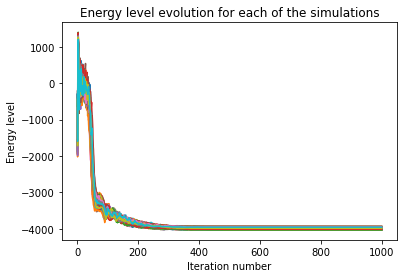

In [25]:
results_annalysis.plot_energies_evolution(energies)

In [32]:
energies[:, -1].min()

-3346.0

In [ ]:
positions = positions[:, :, -1]

In [ ]:
normal_spins = np.sign(positions)

In [ ]:
spins = np.zeros(shape=positions.shape)

In [ ]:
# STEP 1
k = 0.5
spins = np.zeros(shape=positions.shape)
epsilons = np.linalg.norm(positions, axis=1)/np.sqrt(2000)
spins = np.where(np.abs(positions) <= k * epsilons[:, np.newaxis], 0, np.sign(positions))

In [ ]:
np.where(spins == 0)[0].shape

(0,)

In [ ]:
# STEP 2
forces = -np.dot(J, spins.T).T
zero_spins = np.where(spins == 0)
while len(zero_spins[0]) > 0:
    random_index = np.random.choice(len(zero_spins[0]))
    i, j = zero_spins[0][random_index], zero_spins[1][random_index]
    if np.sign(forces[i, j]) != 0:
        spins[i, j] = np.sign(forces[i, j])
    else:
        spins[i, j] = np.random.choice([-1, 1])
    forces = -np.dot(J, spins.T).T
    zero_spins = np.where(spins == 0)

In [ ]:
# STEP 3
spins_indices = np.array(list(range(2000)))
while len(zero_spins[0]) > 0:
    random_index = np.random.choice(len(spins_indices), replace=False)
    selected_index = spins_indices[random_index]
    spins_indices = np.delete(spins_indices, random_index)

    spins[:, selected_index] = np.sign(forces[:, selected_index])
    forces = -np.dot(J, spins.T).T

In [ ]:
tac_spins = spins

In [ ]:
ar = tac_spins == normal_spins
ar[ar==False]

array([], dtype=bool)

In [ ]:
def energie(spins):
    return np.sum(spins @ J * spins, axis=1)

In [ ]:
energie(normal_spins).min(), energie(tac_spins).min()

(-4034.0, -4034.0)

In [ ]:
index = np.where(energies[:, -1] == energies[:, -1].min())[0][0]

In [ ]:
solution = spins[index]

In [ ]:
def calculate_cut_value(adj_matrix, solution):
    cut_value = 0
    for i in range(len(solution)):
        for j in range(len(solution)):
            if solution[i] != solution[j]:
                cut_value += adj_matrix[i][j]
    return cut_value/2

In [ ]:
calculate_cut_value(graph, solution)

11605.0

In [ ]:
normal_cut, tac_cut = calculate_cut_value(graph, normal_spins[0]), calculate_cut_value(graph, tac_spins[0])

In [ ]:
normal_cut, tac_cut

(11569.0, 11569.0)

In [ ]:
current_state = np.zeros(shape=(100, 2000, 2))

for t in range(1, 100):
        #----------------------------------
        # Update de positions and speeds using Euler's scheme
        #----------------------------------
        prev_positions, prev_speeds = current_state[:, :, 0], current_state[:, :, 1]
        current_state[:, :, 0], current_state[:, :, 1] = self.simplectic_update_forall_simulations(prev_positions, prev_speeds, t)
        current_positions = current_state[:, :, 0]

        #----------------------------------
        # Current state energy computation
        #----------------------------------
        current_signed_pos = np.where(current_positions > 0, 1, -1)
        current_energies = np.sum(current_signed_pos @ self.J * current_signed_pos, axis=1) + self.H @ current_signed_pos.T
        current_min_energy = current_energies.min()
        min_energies[t] = current_min_energy
        # energies[:, t] = current_energies

        #--------------------------
        # Global stoping criterion
        #--------------------------
        # Count the number of particles (over all simulations), that have not yet bifurcated
        positions, speeds = (current_state[:, :, 0], current_state[:, :, 1])
        mask = (positions != -1) & (positions != 1) & (speeds != 0)
        number_of_parts_affected = len(positions[mask])
        biffurcation_rate[t] = number_of_parts_affected / (self.n_part * self.n_cond_init)

        # Stop the algorithm if the stopping criterion is reached
        if biffurcation_rate[t] <= self.stopping_criterion:
            best_sim_index = np.argmin(current_energies)
            
            # #--------------------------
            # # TAC Implementation
            # #--------------------------
            # # STEP 1: Binarize
            # k = 0.5
            # spins = np.zeros(shape=positions.shape)
            # epsilons = np.linalg.norm(positions, axis=1)/np.sqrt(self.n_part)
            # spins = np.where(np.abs(positions) <= k * epsilons[:, np.newaxis], 0, np.sign(positions))
            
            # # STEP 2: Stabilize the swing nodess


            return current_state[best_sim_index], min_energies[:t+1], current_energies, biffurcation_rate[:t+1], 
    
    return current_state, min_energies, biffurcation_rate

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 47)

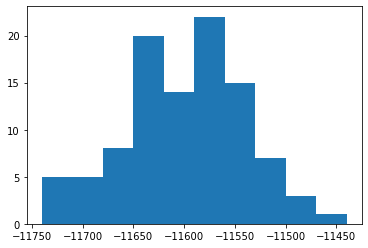

In [ ]:
plt.hist(energies[:, -1], bins='auto');

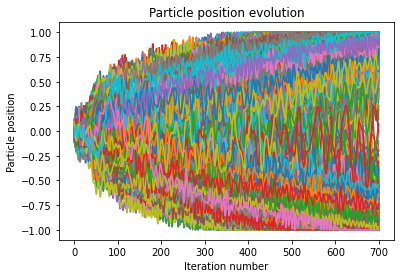

In [ ]:
speeds = states[:, :, :, 1]
positions = states[:, :, :, 0]
n_cond_init, n_particle,  n_iterration = speeds.shape 
abcisses = np.arange(n_iterration)

for i in range(n_particle):
    plt.plot(abcisses, positions[1, i, :])
    plt.xlabel("Iteration number")
    plt.ylabel("Particle position")
    plt.title("Particle position evolution")

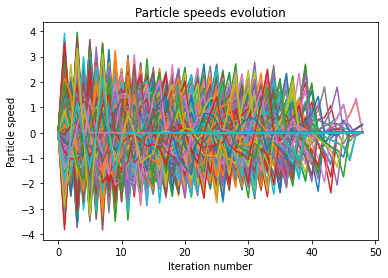

In [ ]:
for i in range(n_particle):
    plt.plot(abcisses, speeds[1, i, :])
    plt.xlabel("Iteration number")
    plt.ylabel("Particle speed")
    plt.title("Particle speeds evolution")

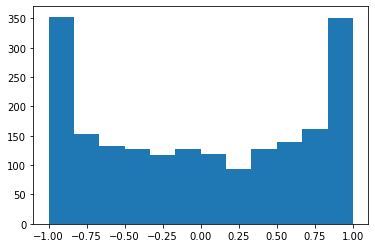

In [ ]:
plt.hist(positions[1, :, 0], bins='auto');

In [ ]:
energies[-1]

array([  0., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240., 240., 240., 240., 240., 240., 240., 240., 240., 240., 240.,
       240.])

In [ ]:
SB_sol = states[:, 0]

## Simulated Annealing

In [ ]:
def calculate_cut_value(adj_matrix, solution):
    cut_value = 0
    for i in range(len(solution)):
        for j in range(len(solution)):
            if solution[i] != solution[j]:
                cut_value += adj_matrix[i][j]
    return cut_value

def simulated_annealing(adj_matrix, time_limit):
    # Initialize with a random solution
    current_solution = np.random.choice([0, 1], size=(adj_matrix.shape[0],))
    best_solution = np.copy(current_solution)
    current_cut_value = calculate_cut_value(adj_matrix, current_solution)
    best_cut_value = current_cut_value
    
    # Parameters for the annealing schedule
    temp = 1.0
    cooling_rate = 0.99
    
    start_time = time.time()
    
    while time.time() - start_time < time_limit:
        # Create a new neighbor solution
        new_solution = np.copy(current_solution)
        # Flip a random bit to create a neighbor solution
        flip_index = random.randint(0, len(new_solution) - 1)
        new_solution[flip_index] = 1 - new_solution[flip_index]
        
        new_cut_value = calculate_cut_value(adj_matrix, new_solution)
        
        # Determine if we should accept the new solution
        if new_cut_value > current_cut_value:
            current_solution = new_solution
            current_cut_value = new_cut_value
            if new_cut_value > best_cut_value:
                best_solution = new_solution
                best_cut_value = new_cut_value
        else:
            # Accept with a certain probability if the new solution is worse
            if random.random() < math.exp((new_cut_value - current_cut_value) / temp):
                current_solution = new_solution
                current_cut_value = new_cut_value
        
        # Decrease the temperature
        temp *= cooling_rate
    
    return best_solution, best_cut_value

In [ ]:
def simulated_annealing_max_cut(G, time_limit):
    # Initial random partition
    partition = np.random.choice([0, 1], size=len(G.nodes))
    best_partition = np.copy(partition)
    best_cut_value = nx.cut_size(G, np.where(partition == 0)[0], np.where(partition == 1)[0])

    # Set initial temperature and cooling schedule
    T = 10.0
    T_min = 0.001
    alpha = 0.9

    start_time = time.time()

    while time.time() - start_time < time_limit:
        for i in range(100):  # Perform 100 iterations at each temperature
            # Pick a random node and toggle its part
            node = random.choice(list(G.nodes))
            partition[node] = 1 - partition[node]

            # Calculate the cut value
            current_cut_value = nx.cut_size(G, np.where(partition == 0)[0], np.where(partition == 1)[0])

            # Check if the new partition is better or accepted by the probability
            delta = current_cut_value - best_cut_value
            if delta > 0 or random.random() < np.exp(delta / T):
                if delta > 0:
                    best_cut_value = current_cut_value
                    best_partition = np.copy(partition)
            else:
                # Revert the change
                partition[node] = 1 - partition[node]

        # Cool down the temperature
        T = max(T_min, T * alpha)

    return best_partition, best_cut_value

In [ ]:
SA_sol, SA_energy = simulated_annealing_max_cut(nx.DiGraph(graph), 40)

In [ ]:
SA_score, SB_score = calculate_cut_value(graph, SA_sol), calculate_cut_value(graph, SB_sol)

In [ ]:
SA_score, SB_score

(22534.0, 25948.0)